In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import halfspace.load as hs
import halfspace.projections as hsp
import halfspace.sandbox as hbx
import scipy.ndimage as nd
import h5py
import json

In [3]:
fault_slip_file = '../data/fault_data/all_fault_pts.csv'
dem_metadata_file = '../data/dem/s_tibet_dem_meta.json'
stress_file = '../stress_arrays/nepal_topo_stress.h5'

In [4]:
d_meta = json.load(open(dem_metadata_file, 'r')) # DEM metadata dictionary
fault_df = pd.read_csv(fault_slip_file, index_col=0)  # fault slip DataFrame

stress_db = h5py.File(stress_file, 'r')     # open wrapper for stress files
stress_shape = stress_db['xx_MPa'][:,:,0].shape   # size of the stress arrays

In [5]:
x_res = int(d_meta['x_res_m'])  # get info from metadata dict
y_res = int(d_meta['y_res_m'])
z_res = 500
b_conv_mode = 'valid'
c_conv_mode = 'same'

z_min = z_res
z_max = z_min + 25000
z_len = int( (z_max - z_min) / z_res + 1)
z_vec = np.linspace(z_min, z_max, num=z_len)
topo_res = x_res

In [6]:
stress_db['xx_MPa']

<HDF5 dataset "xx_MPa": shape (1603, 2818, 51), type "<f8">

In [7]:
fault_df.head()

,east,north,depth,strike,dip,slip_m,rake,fault_name,point_index,htm_ind
0,210702.346219,3295884.106254,4623,19.761917,55,0.05,-90,NaN,0,30
1,205435.348084,3287130.049210,4762,19.761917,55,0.05,-90,NaN,1,30
2,200405.436713,3267428.950486,4831,19.761917,55,0.05,-90,NaN,2,30
3,200853.134701,3259918.710871,4677,19.761917,55,0.05,-90,NaN,3,30
4,198732.170284,3242085.302656,4797,19.761917,55,0.05,-90,NaN,4,30


In [8]:
fault_df.depth.max(), fault_df.depth.min()

(5727.0, -28023.6)

In [9]:
e_range_dem = np.linspace(d_meta['east_min'], d_meta['east_max'], # orig dem
                          num=d_meta['n_cols'])
n_range_dem = np.linspace(d_meta['north_min'], d_meta['north_max'], 
                          num=d_meta['n_rows'])

e_range = hs._centered(e_range_dem, stress_shape[1])  # cut down to final size
n_range = hs._centered(n_range_dem, stress_shape[0])

x0 = e_range[0]  # first index
y0 = n_range[0]

In [10]:
fault_xyz = hbx.coord_map_inverse_3d([ fault_df.east.values,
                                       fault_df.north.values,
                                       fault_df.depth.values],
                                     x_step=x_res, x_shift=x0,
                                     y_step=y_res, y_shift=y0,
                                     z_step=-z_res, z_shift=-z_vec.min())

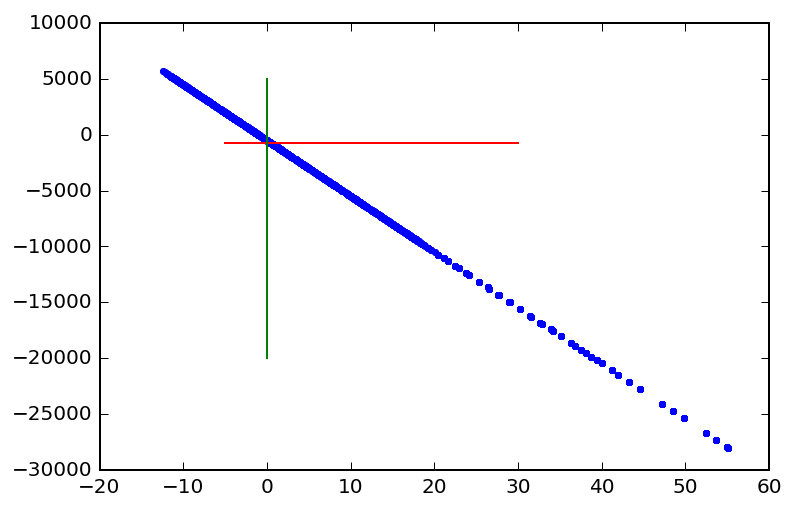

In [11]:
plt.plot(fault_xyz[2], fault_df.depth, '.')

plt.plot([-5, 30], [-700, -700], 'r')
plt.plot([0, 0], [5000, -20000], 'g')

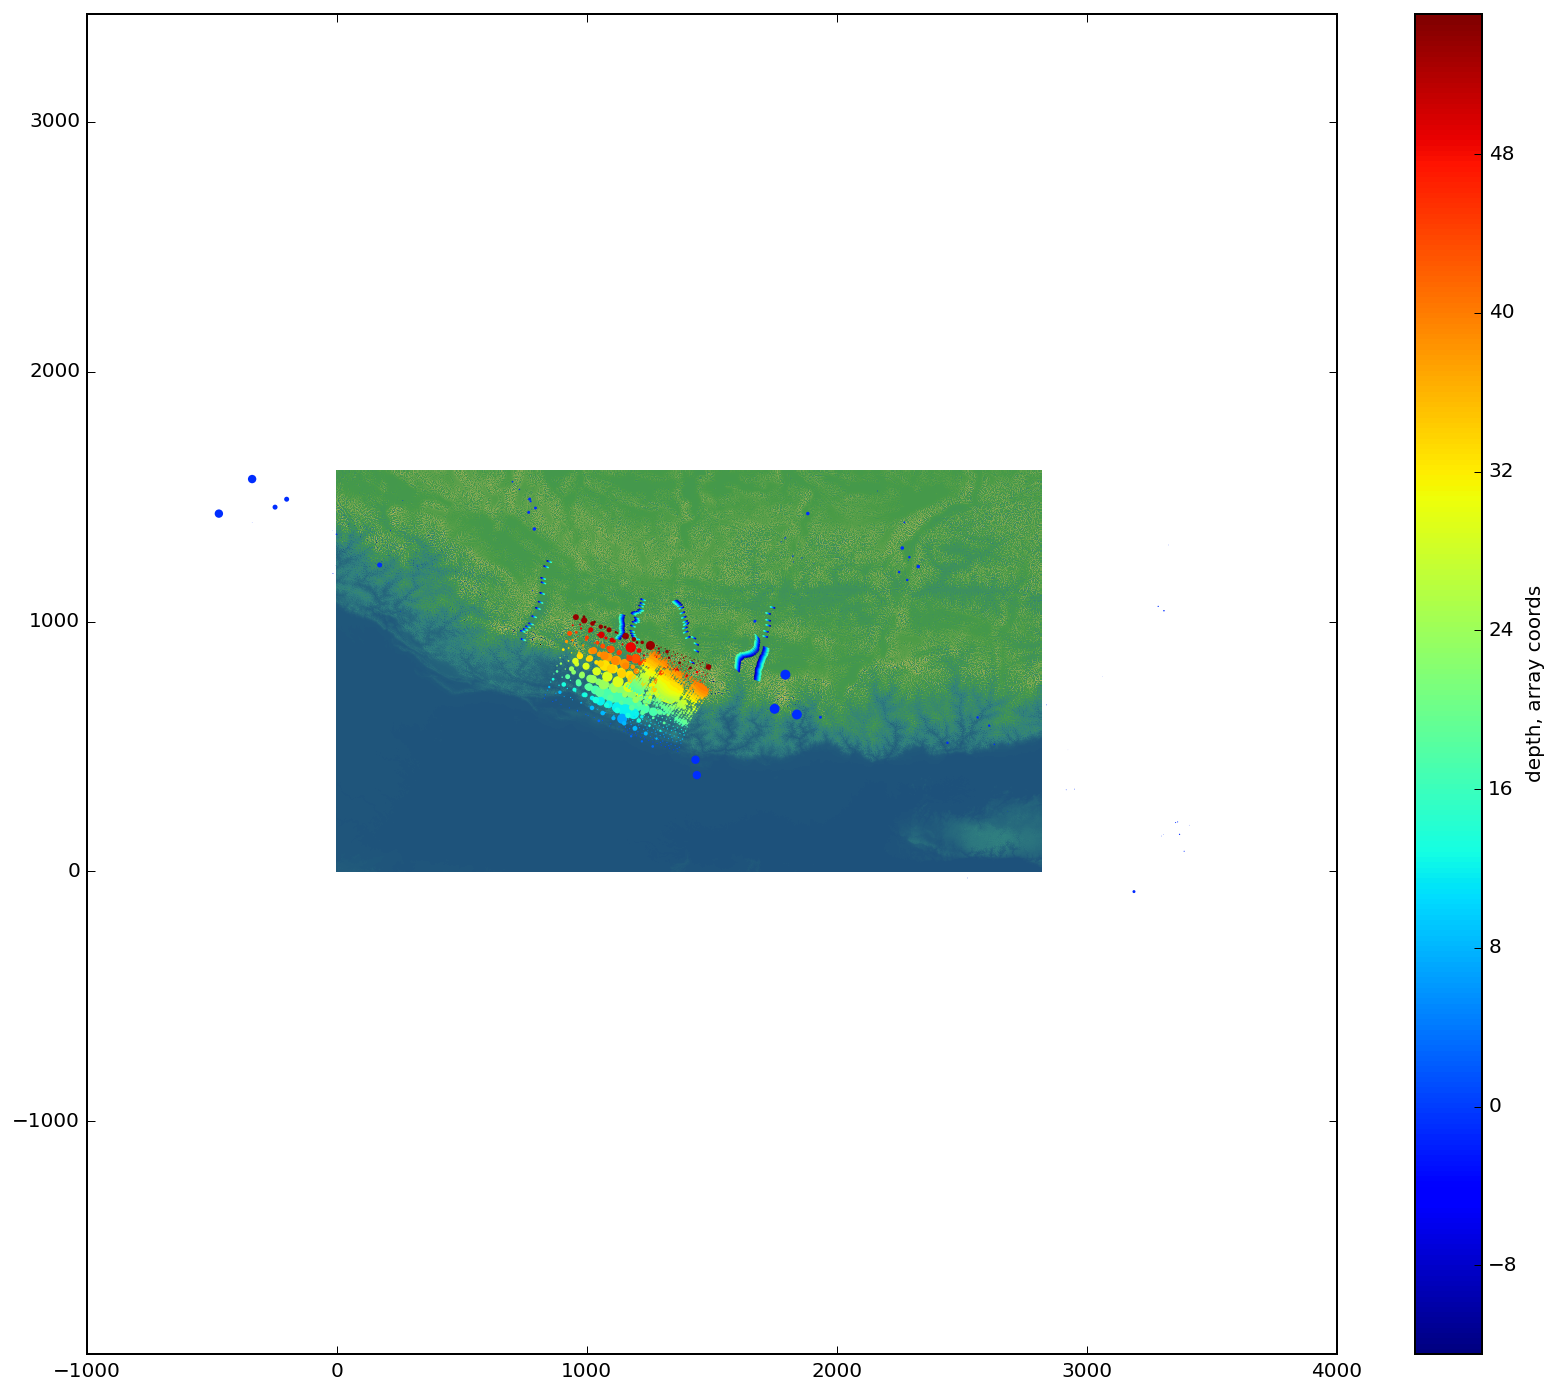

In [12]:
plt.figure(figsize=(14,12))

plt.pcolormesh(stress_db['zz_MPa'][:,:,0], cmap=plt.cm.gist_earth)
plt.scatter(fault_xyz[0], fault_xyz[1], c=fault_xyz[2],
            s=fault_df.slip_m*10, lw=0)
plt.colorbar(label='depth, array coords')

plt.axis('equal')

plt.show()

In [13]:
comp_list = ['zz', 'xy', 'xz', 'yz', 'xx', 'yy']

for comp in comp_list:
    print('interpolating {} stresses'.format(comp) )
    fault_df['{}_stress'.format(comp)] = nd.map_coordinates(
                                            stress_db['{}_MPa'.format(comp)][:,:,:],
                                            [fault_xyz[1], fault_xyz[0], fault_xyz[2]],
                                            order=1)

interpolating zz stresses
interpolating xy stresses
interpolating xz stresses
interpolating yz stresses
interpolating xx stresses
interpolating yy stresses


In [14]:
fault_df['tau_dd'] = 0.
fault_df['tau_ss'] = 0.
fault_df['sig_nn'] = 0.

stress_tens_xyz = {}

for i, fault_patch in enumerate(fault_df.index):
    stress_tens_xyz[i] = hsp.make_xyz_stress_tensor( 
                                     sig_xx = fault_df.xx_stress.iloc[i],
                                     sig_yy = fault_df.yy_stress.iloc[i],
                                     sig_zz = fault_df.zz_stress.iloc[i],
                                     sig_xy = fault_df.xy_stress.iloc[i],
                                     sig_xz = fault_df.xz_stress.iloc[i],
                                     sig_yz = fault_df.yz_stress.iloc[i])

    fault_df['tau_dd'].iloc[i] = hsp.dip_shear_stress_from_xyz(
                                  fault_df.strike.iloc[i], fault_df.dip.iloc[i],
                                  stress_tens_xyz[i] )

    fault_df['tau_ss'].iloc[i] = hsp.strike_shear_stress_from_xyz(
                                  fault_df.strike.iloc[i], fault_df.dip.iloc[i],
                                  stress_tens_xyz[i] )

    fault_df['sig_nn'].iloc[i] = hsp.normal_stress_from_xyz(
                                  fault_df.strike.iloc[i], fault_df.dip.iloc[i],
                                  stress_tens_xyz[i] )

/home/ubuntu/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


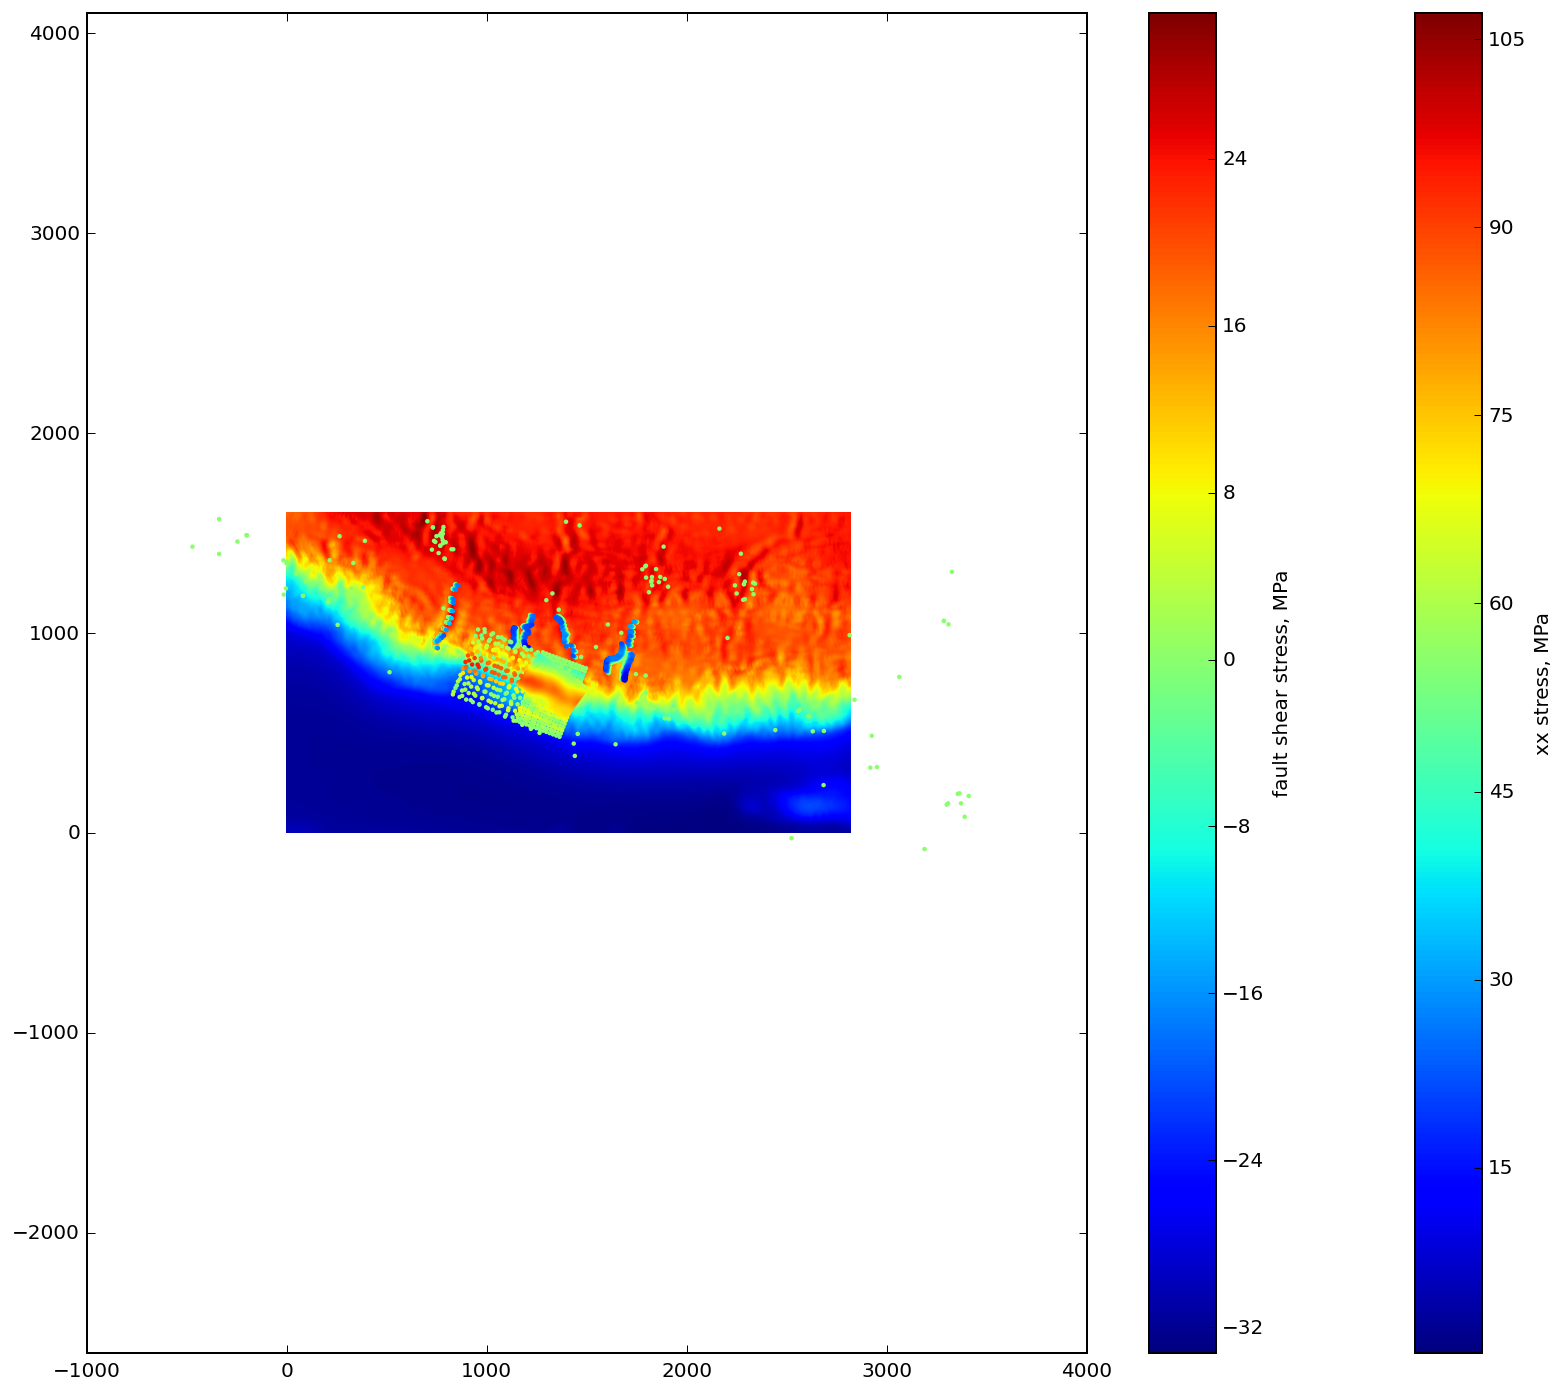

In [15]:
plt.figure(figsize=(14,12))

comp = 'xx'

plt.pcolormesh(stress_db['{}_MPa'.format(comp)][:,:,10])#, cmap=plt.cm.gist_earth)
plt.colorbar(label='{} stress, MPa'.format(comp))

plt.scatter(fault_xyz[0], fault_xyz[1], c=fault_df.tau_dd,
            s=5, lw=0)
plt.colorbar(label='fault shear stress, MPa'.format(comp))

plt.axis('equal')

plt.show()

In [16]:
fault_df_clip = fault_df[fault_df.xx_stress != 0.]

In [17]:
fault_df_clip.shape

(2056, 19)

In [18]:
fault_df_clip.to_csv('../data/fault_data/fault_pts_stresses.csv')